### 1. Setting Environment

In [12]:
import os
kaggle_username = "yuvarajusiripireddy"
kaggle_key = "5215d670a47c5ae197fce95733c3da4c"

# Write the API credentials to kaggle.json
os.environ['KAGGLE_USERNAME'] = kaggle_username
os.environ['KAGGLE_KEY'] = kaggle_key



### 2. Install Kaggle CLI & Download Dataset

In [13]:
# !pip install -q kaggle

# # Download the dataset
# !kaggle datasets download -d chethuhn/network-intrusion-dataset

# # Unzip it
# !unzip -q network-intrusion-dataset.zip -d cicids2017_data

# # Check contents
# !ls cicids2017_data


### 3: Load Data and Cleaning

In [14]:
import numpy as np
import pandas as pd # Import pandas

# Assuming your data is in a CSV file within cicids2017_data, adjust the file name if necessary
df = pd.read_csv('cicids2017_data/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv') # Load data into a DataFrame

# Drop unwanted columns (non-numeric identifiers)
df.drop(columns=['Flow ID', ' Source IP', ' Destination IP', ' Timestamp'], inplace=True, errors='ignore')

# Drop non-numeric columns if any remain
df = df.select_dtypes(include=[np.number])

# Handle NaNs and Infs
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

print("Cleaned Shape:", df.shape)


Cleaned Shape: (225711, 78)


### 4. Normalize Features

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

df_scaled.head()


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,0.837225,3.333335e-08,0.000518,0.00000,0.000066,0.000000,0.000514,0.004076,0.001552,0.0,...,0.000518,0.384615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.840109,9.166671e-07,0.000000,0.00034,0.000033,0.000001,0.000514,0.004076,0.001552,0.0,...,0.000000,0.384615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.840124,4.416669e-07,0.000000,0.00034,0.000033,0.000001,0.000514,0.004076,0.001552,0.0,...,0.000000,0.384615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.705548,2.916668e-07,0.000000,0.00034,0.000033,0.000001,0.000514,0.004076,0.001552,0.0,...,0.000000,0.384615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.837194,3.333335e-08,0.000518,0.00000,0.000066,0.000000,0.000514,0.004076,0.001552,0.0,...,0.000518,0.384615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 5. Prepare Input for LSTM-AE

In [16]:
from sklearn.model_selection import train_test_split

X = df_scaled.values
X = X.reshape((X.shape[0], X.shape[1], 1))  # Shape: (samples, timesteps, features)

X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (180568, 78, 1)
Test shape: (45143, 78, 1)


### 6. Define LSTM-AE Model  

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

timesteps = X_train.shape[1]
n_features = 1

inputs = Input(shape=(timesteps, n_features))
encoded = LSTM(64, activation='relu')(inputs)
encoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(encoded)
decoded = TimeDistributed(Dense(1))(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 78, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 78, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 78, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 78, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

### 7. Train the Model

In [25]:
history = autoencoder.fit(X_train, X_train,
                          epochs=50,
                          batch_size=128,
                          validation_split=0.1,
                          shuffle=True)


Epoch 1/50
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.0645 - val_loss: 0.0624
Epoch 2/50
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.0602 - val_loss: 0.0579
Epoch 3/50
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 0.0577 - val_loss: 0.0569
Epoch 4/50
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 0.0569 - val_loss: 0.0569
Epoch 5/50
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 0.0566 - val_loss: 0.0564
Epoch 6/50
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 0.0560 - val_loss: 0.0557
Epoch 7/50
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - loss: 0.0554 - val_loss: 0.0553
Epoch 8/50
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - loss: 0.0553 - val_loss: 0.0554
Epoch 9/50
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.0549 - val_loss: 0.0548
Epoch 10/50
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 0.0545 - val_loss: 0.0534
Epoch 11/50
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.0511 - val_loss: 0.0492
Epoch 12

### 8. Plot Training & Validation Loss

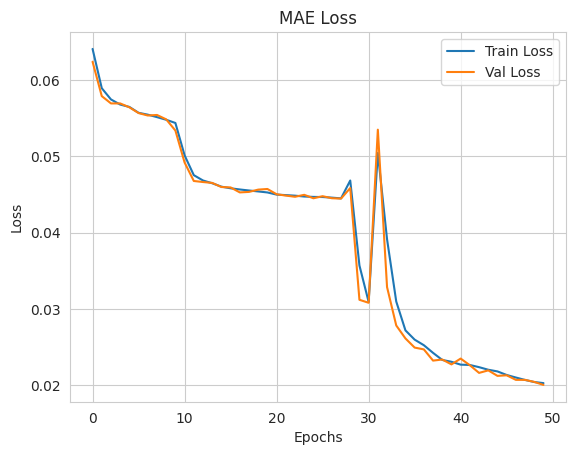

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("MAE Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


### 9. Reconstruct and Calculate MAE

In [27]:
X_pred = autoencoder.predict(X_test)
mae_loss = np.mean(np.abs(X_pred - X_test), axis=(1, 2))

threshold = np.percentile(mae_loss, 95)
print("Reconstruction Error Threshold:", threshold)


1411/1411 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
Reconstruction Error Threshold: 0.05381385006083389


### 10. Classify Anomalies

In [28]:
# 1 = Anomaly, 0 = Normal
y_pred = (mae_loss > threshold).astype(int)
print("Anomalies Detected:", np.sum(y_pred))


Anomalies Detected: 2258


### 11. Visualize MAE Distribution

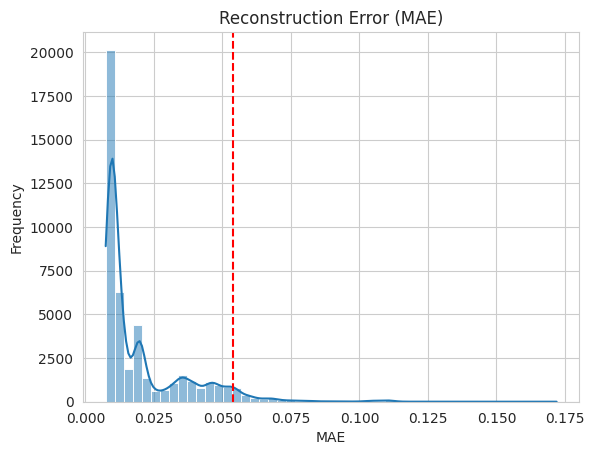

In [29]:
import seaborn as sns

sns.set_style("whitegrid")
sns.histplot(mae_loss, bins=50, kde=True)
plt.axvline(threshold, color='red', linestyle='--')
plt.title("Reconstruction Error (MAE)")
plt.xlabel("MAE")
plt.ylabel("Frequency")
plt.show()
